# **Time Series Regression Analysis (Corporation Favorita)**


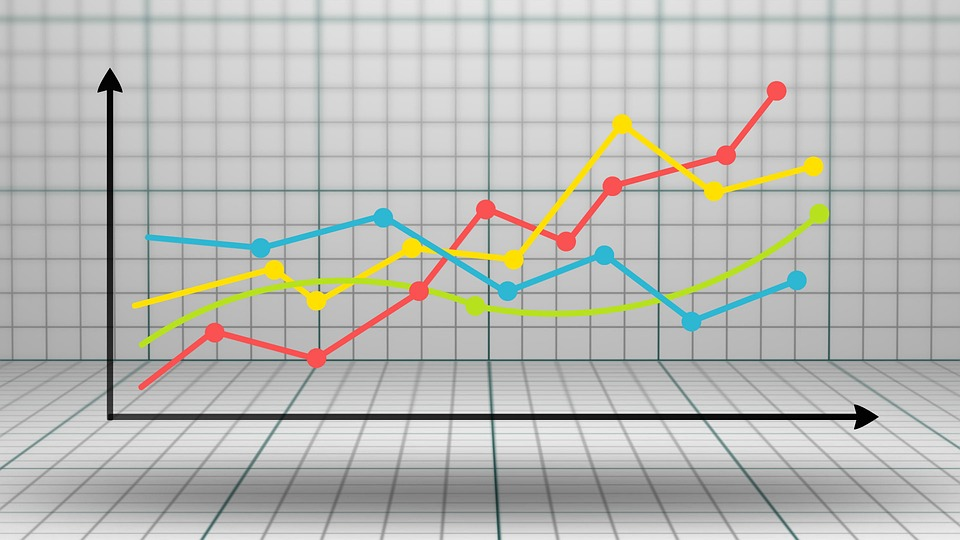

# **1. Business Understanding**

Predicting sales is crucial for business planning. In this project, we'll use machine learning to build a model that forecasts store sales. We'll use data from Corporation Favorita, a leading grocery retailer in Ecuador.

## **Project Objective**

Our main goal is to create a Machine Learning Model that predicts unit sales for various items sold in Favorita stores.

We'll analyze sales trends over time to understand customer behavior, identify seasonal patterns, and recognize other factors affecting sales. Factors like oil prices, holidays, and promotions can impact sales at Favorita. By analyzing this data, we aim to provide valuable insights to grocery retailers about customer preferences and behavior.

Further, by examining data on customer purchases, demographics, and social media activity, retailers can better understand what drives their customers. This information can help tailor marketing strategies to boost sales. Additionally, it can help identify slow-selling products, optimize inventory, reduce costs, and increase profits—especially for perishable items like dairy and meat.

We'll also look into improving checkout processes to enhance the shopping experience.

In summary, accurate sales forecasting helps businesses plan better, manage inventory efficiently, and make informed decisions. This precision enables companies like Favorita to reduce costs and increase profitability.

## **Approach and Methodology**

This project will adhere to the CRISP-DM (Cross-Industry Standard Process for Data Mining) Framework, a widely recognized methodology for data science projects. We will explore various machine learning techniques to achieve accurate sales predictions, including but not limited to:

**1. Time Series Forecasting**

Employing ARIMA, LSTM, or Prophet to detect sales trends and seasonal variations.

**2. Regression Models**

Utilizing linear regression, decision trees, random forests, or gradient boosting to evaluate factors such as promotions, product attributes, and store specifics.


## **Hypothesis**

H0(Null Hypothesis) -   
Ha(Alternative Hypothesis) -

## **Research Questions**
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest 
sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store
sales.

# **Data Understanding**

In [1]:
# Load the necessary libraries
import dotenv
from dotenv import dotenv_values
import pyodbc
import pandas as pd
import warnings
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy
pd.options.display.float_format = '{:.2f}'.format
sns.set_style('white')
warnings.filterwarnings("ignore")


In [2]:
# Load .env values
environment_variables = dotenv_values(".env")

# Get .env values
server =  environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Create a connection string
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [3]:
# Connect to the database
connection = pyodbc.connect(connection_string)

In [4]:
# Get data from table dbo.oil in the database
query_dbo_oil = "SELECT * FROM dbo.oil"
oil_data = pd.read_sql(query_dbo_oil, connection)
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [5]:
# Load data from dbo.holidays_events table in the database
query_dbo_holidays_events = "SELECT * FROM dbo.holidays_events"
holidays_events_data = pd.read_sql(query_dbo_holidays_events, connection)
holidays_events_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
# Load data from dbo.stores table in the database
query_dbo_stores = "SELECT * FROM dbo.stores"
stores_data = pd.read_sql(query_dbo_stores, connection)
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
# Define the path to the zip file
zip_file_path = "Zip Files/store-sales-forecasting.zip"

# Define the extraction directory
extract_dir = "Data"

# List of files to extract
files_to_extract = ["train.csv", "transactions.csv"]

# Extract files
with zipfile.ZipFile(zip_file_path, 'r') as zObject:
    for file_name in files_to_extract:
        zObject.extract(file_name, os.path.join(extract_dir, file_name))

print("Extraction completed.")

Extraction completed.


In [8]:
# Load train and transaction data 
# The data was downloaded from a GitHub repo (https://github.com/Azubi-Africa/Career_Accelerator_LP3-Regression/blob/main/store-sales-forecasting.zip)
train_data=pd.read_csv(r"Data\train.csv\train.csv", parse_dates =['date'])
transaction_data=pd.read_csv(r"Data\transactions.csv\transactions.csv", parse_dates =['date'])
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [9]:
transaction_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


## **EDA**

### **Oil Data**

- Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)
## Note
- The term "dcoilwtico" refers to the daily crude oil price for West Texas Intermediate (WTI) crude oil

In [10]:
# Describe the oil data numerical values
oil_data.describe()

,dcoilwtico
count,1175.00
mean,67.71
std,25.63
min,26.19
25%,46.41
50%,53.19
75%,95.66
max,110.62


In [11]:
# Describe oil data categorical values
oil_data.describe(include='object')


,date
count,1218
unique,1218
top,2013-01-01
freq,1


In [12]:
# Check for null values in the oil data 
print(f"Oil data null values: \n{oil_data.isnull().sum()}")

Oil data null values: 
date           0
dcoilwtico    43
dtype: int64


In [13]:
# Check for duplicates in the oil data
print(f"Oil data duplicates: \n{oil_data.duplicated().sum()}")

Oil data duplicates: 
0


In [14]:
# Check information for oil data
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [15]:
# copying oil data for plotting
oil_data_cp=oil_data.copy()

oil_data_cp
# Converting 'date' to datetime format
oil_data_cp['date'] = pd.to_datetime(oil_data_cp['date'])
# Settting 'date' as the index
oil_data_cp.set_index('date', inplace=True)

# Grouping the data by year and summing the 'dcoilwtico' values
grouped_data = oil_data_cp.resample('Y')['dcoilwtico'].mean()


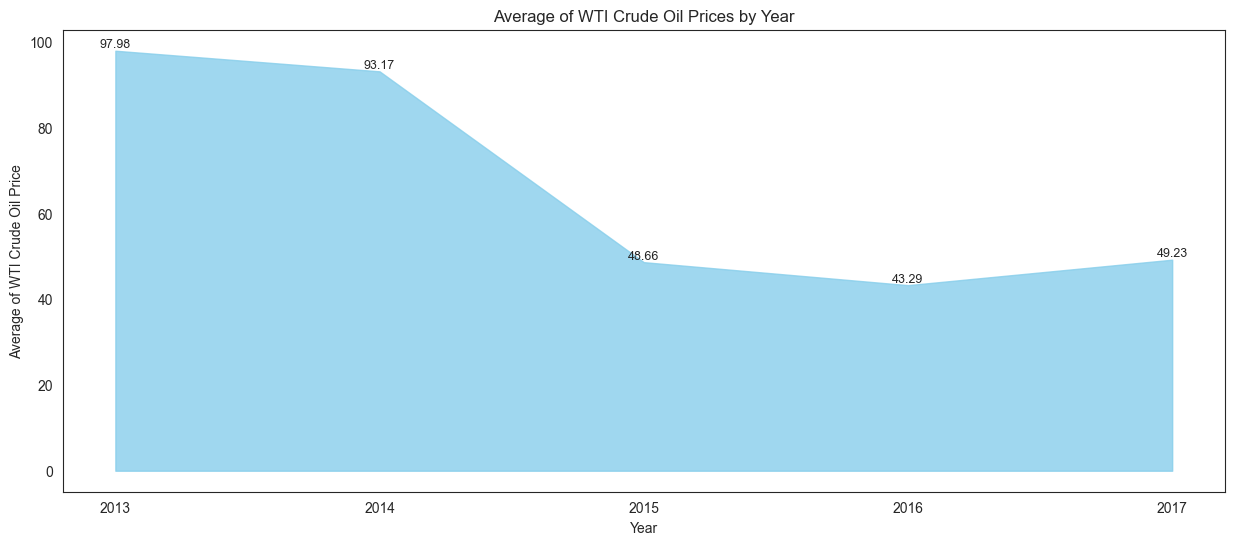

In [16]:
# Plotting area chart 
plt.figure(figsize=(15, 6))
plt.fill_between(grouped_data.index.year, grouped_data.values, color='skyblue', alpha=0.8)

# Adding data labels
for i, value in enumerate(grouped_data.values):
    plt.text(grouped_data.index.year[i], value, str(round(value, 2)), ha='center', va='bottom', fontsize=9)

plt.xticks(grouped_data.index.year)
plt.xlabel('Year')
plt.ylabel('Average of WTI Crude Oil Price')
plt.title('Average of WTI Crude Oil Prices by Year')
plt.show()

## **Issues with the oil data**
- There are 43 missing values in oild data. Partcularaly the dcoilwtico column
- The date column is an object instaed of datetime

### **Holiday events Data**

- Holidays and Events, with metadata
NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [17]:
# Get info of the holiday events database
holidays_events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [18]:
# Check for null values in the holiday events data
holidays_events_data.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [19]:
# Check for duplicates in the holiday events data
holidays_events_data.duplicated().sum()

0

In [20]:
# Unique holiday events
holidays_events_data['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [21]:
# Unique holiday types
holidays_events_data['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [22]:
# Unique locale names
holidays_events_data['locale_name'].unique()

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

### Notes
- The date column is an object instead of datetime
- We need to change tranferrefd column from bool to object/category
- There are no null values
- There are no duplicates

### **Stores Data**

- Store metadata, including city, state, type, and cluster.

- cluster is a grouping of similar stores.

In [23]:
# View first 5 rows
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [24]:
# Get info of the stores dataset
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [25]:
# Get all unique store numbers
stores_data['store_nbr'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54], dtype=int64)

In [26]:
# Get all unique cities 
stores_data['city'].unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [27]:
# Get all unique clusters
stores_data['cluster'].unique()

array([13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17],
      dtype=int64)

In [28]:
# Get all unique type of stores
stores_data['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [29]:
# Check for duplicates
stores_data.duplicated().sum()

0

In [30]:
# Check for null values
stores_data.isna().sum()   

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

### **Training data**

- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

- store_nbr identifies the store at which the products are sold.

- family identifies the type of product sold.

- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [31]:
# Get first 5 rows
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [32]:
# Check for nulls in train_data
train_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [33]:
# Check for duplicates in train_data
train_data.duplicated().sum()

0

In [34]:
# Describe the numerical columns in train data
train_data.drop(['id', 'store_nbr'], axis=1).describe()

,date,sales,onpromotion
count,3000888,3000888.00,3000888.00
mean,2015-04-24 08:27:04.703088384,357.78,2.60
min,2013-01-01 00:00:00,0.00,0.00
25%,2014-02-26 18:00:00,0.00,0.00
50%,2015-04-24 12:00:00,11.00,0.00
75%,2016-06-19 06:00:00,195.85,0.00
max,2017-08-15 00:00:00,124717.00,741.00
std,NaN,1102.00,12.22


In [35]:
# Describe the categoricainclus columns in train data
train_data.describe(include='object')

,family
count,3000888
unique,33
top,AUTOMOTIVE
freq,90936


In [36]:
# Get information about the data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [37]:
# Get unique family names
train_data['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

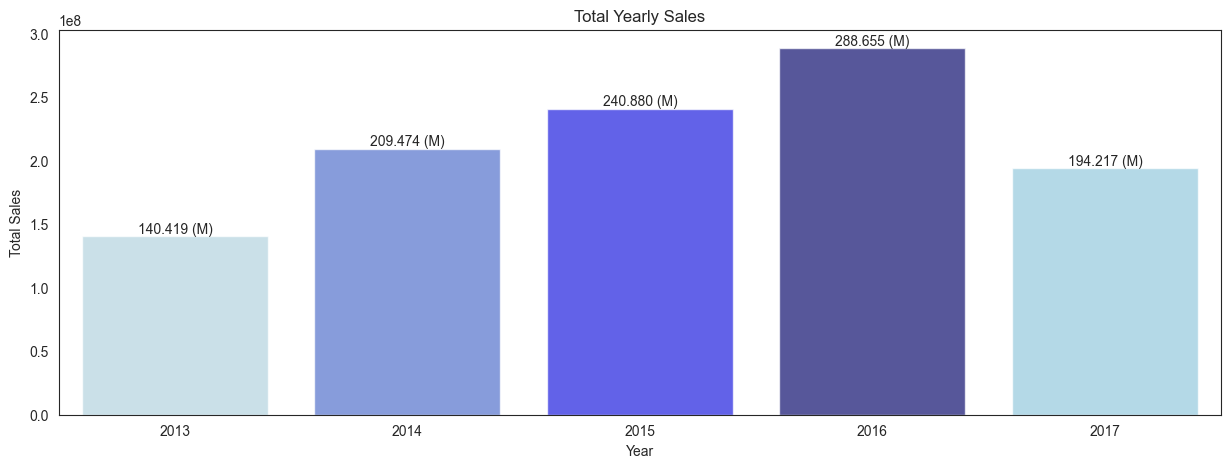

In [38]:
# Copy the train data
train_data_cp = train_data.copy()

# Extracting year from the 'date' column and setting it as index
train_data_cp.set_index(train_data_cp['date'].dt.year, inplace=True)
train_data_cp.index.name = 'year'  # Naming the index as 'year'

# Grouping by year and summing the sales
total_yearly_sales = train_data_cp.groupby('year')['sales'].sum()
# Plotting the total yearly sales with a bar plot
custom_palette = ['lightblue', 'royalblue', 'blue', 'navy', 'skyblue']
plt.figure(figsize=(15,5))
barplot = sns.barplot(x=total_yearly_sales.index, y=total_yearly_sales.values, palette=custom_palette, alpha=0.7)
for index, value in enumerate(total_yearly_sales):
    label = f'{value /1e6:.3f} (M)'  # Format value in Millions
    barplot.text(index, value, label, ha='center', va='bottom')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Yearly Sales')
plt.show()

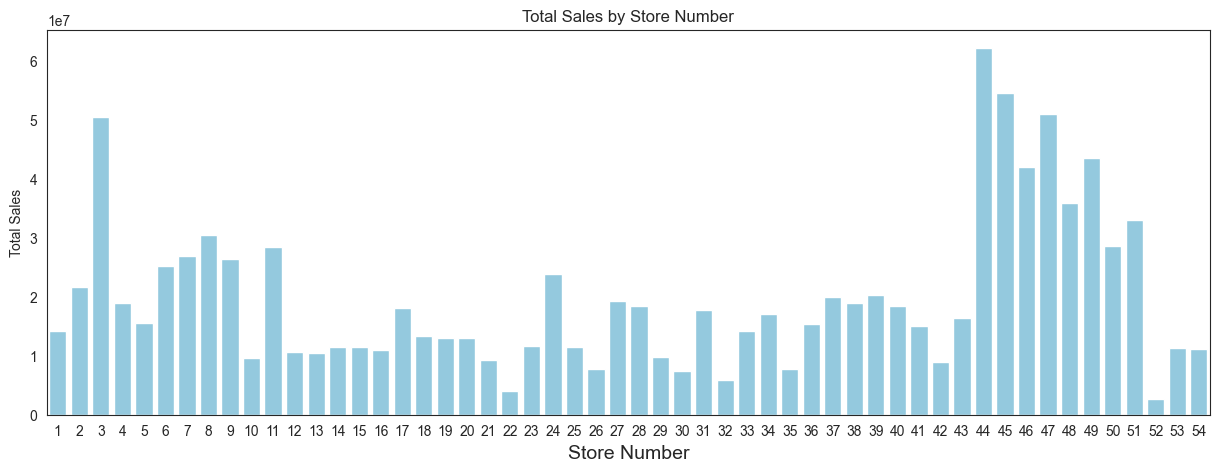

In [39]:
# Grouping by year and summing the sales
total_yearly_sales = train_data_cp.groupby('store_nbr')['sales'].sum()

# Plotting the total yearly sales with a bar plot
plt.figure(figsize=(15,5))
barplot = sns.barplot(x=total_yearly_sales.index, y=total_yearly_sales.values, color='skyblue', alpha=1)
plt.xlabel('Store Number', fontsize=14)
plt.ylabel('Total Sales')
plt.title('Total Sales by Store Number')
plt.show()

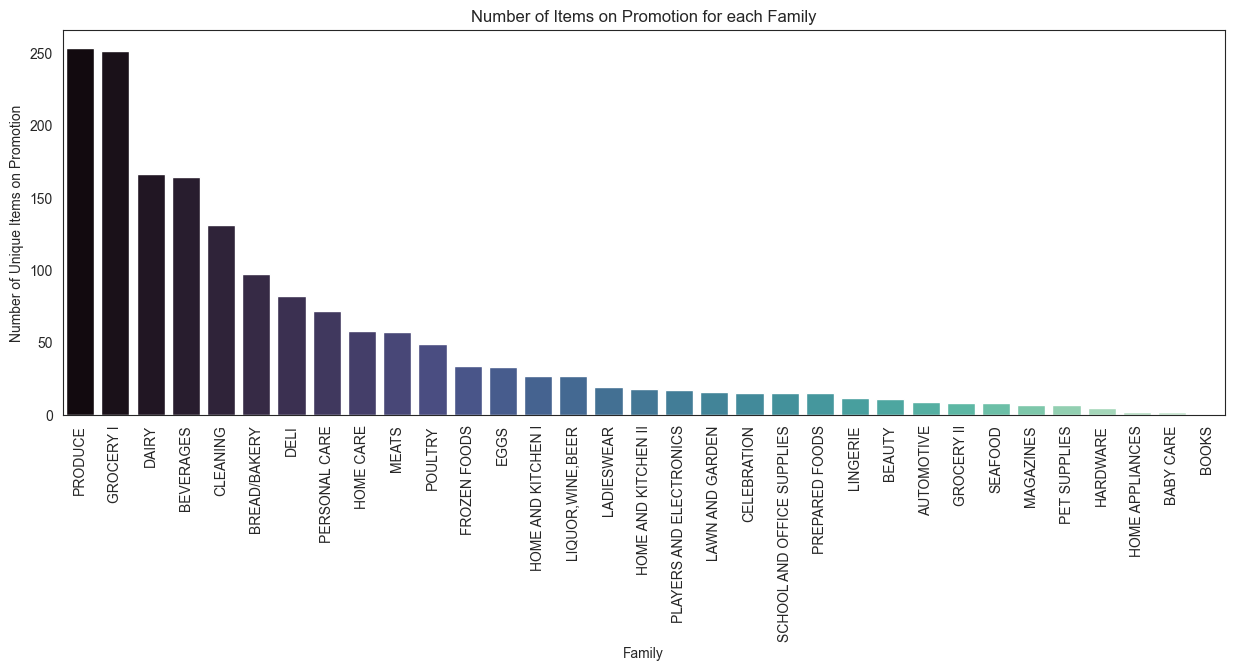

In [40]:
# Plot number of unique items on promotion for each family
plt.figure(figsize=(15,5))
train_data_cp_promotion = train_data_cp.groupby('family')['onpromotion'].nunique().sort_values(ascending=False)
ax = sns.barplot(train_data_cp_promotion, palette='mako')
plt.title('Number of Items on Promotion for each Family')
plt.xlabel('Family')
plt.ylabel('Number of Unique Items on Promotion')
plt.xticks(rotation=90)
plt.show()

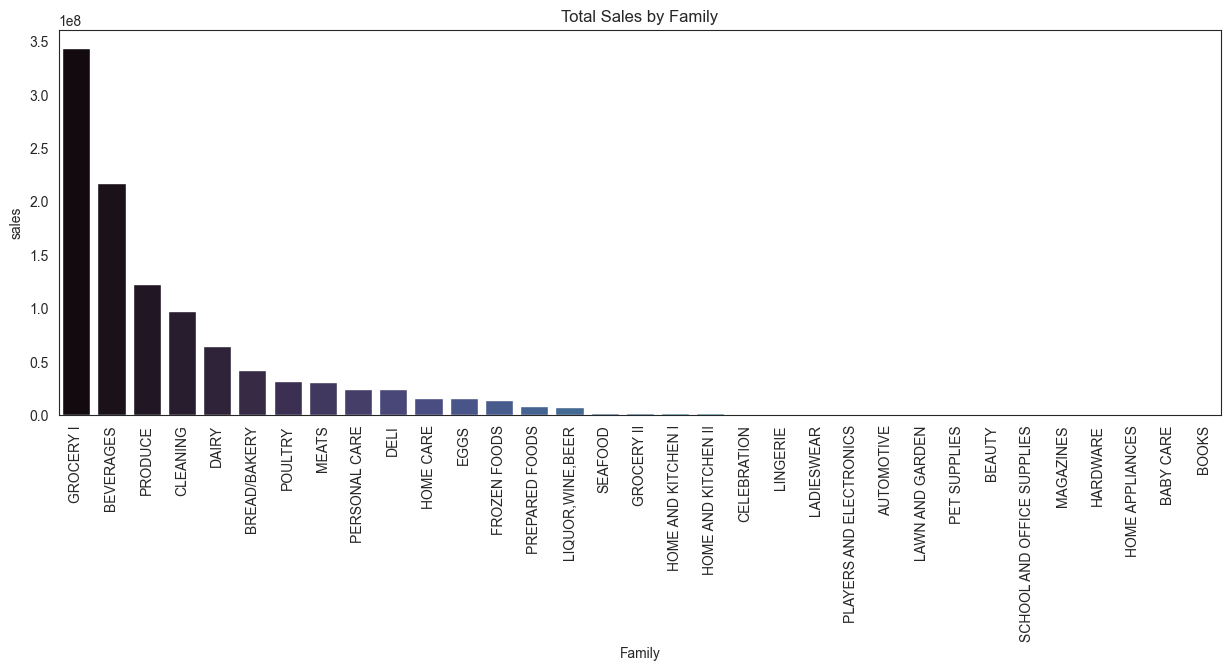

In [41]:
# Plot plot total saled for each family
plt.figure(figsize=(15,5))
train_data_cp_promotion = (train_data_cp.groupby('family')['sales'].sum()).sort_values(ascending=False)
ax = sns.barplot(train_data_cp_promotion, palette='mako')
plt.title('Total Sales by Family')
plt.xlabel('Family')
plt.xticks(rotation=90)
plt.show()

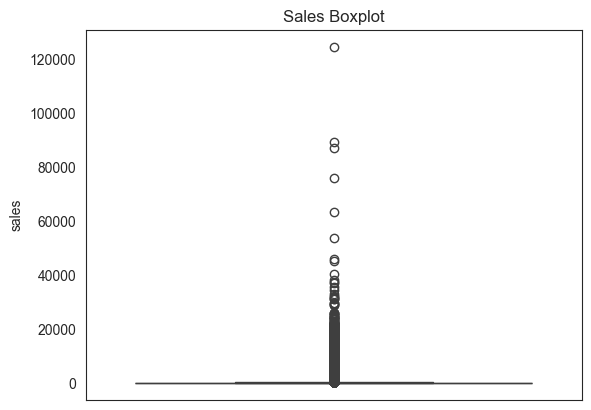

In [42]:
# Sales boxplot
sns.boxplot(train_data_cp['sales'])
plt.title('Sales Boxplot')
plt.show()


<Axes: ylabel='onpromotion'>

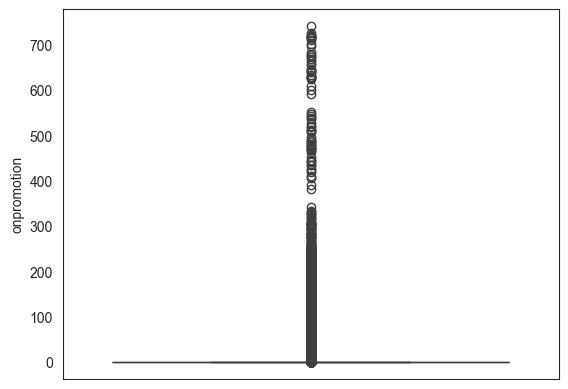

In [43]:
# Onpromotion boxplot
sns.boxplot(train_data_cp['onpromotion'])

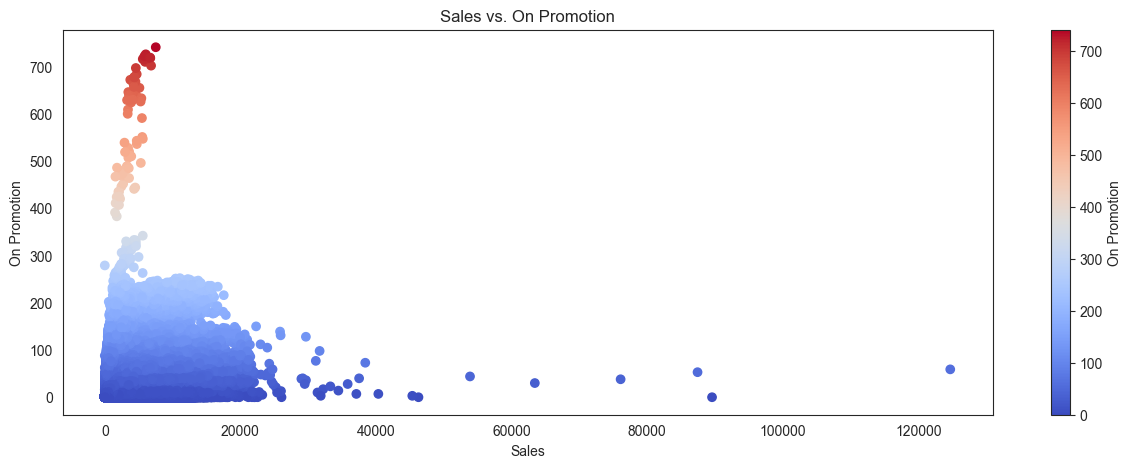

In [44]:
# Extracting sales and onpromotion data
sales = train_data_cp['sales']
on_promotion = train_data_cp['onpromotion']

# Plotting scatter plot with different colors for onpromotion
plt.figure(figsize=(15, 5))
plt.scatter(sales, on_promotion, c=on_promotion, cmap='coolwarm')
plt.xlabel('Sales')
plt.ylabel('On Promotion')
plt.title('Sales vs. On Promotion')
plt.colorbar(label='On Promotion')
plt.show()

## **Transaction Data**

In [45]:
# Check for data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [46]:
# Check for nulls
transaction_data.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [47]:
# Check for duplicates
transaction_data.duplicated().sum()

0

In [48]:
# Describe data
transaction_data.describe()

,date,store_nbr,transactions
count,83488,83488.00,83488.00
mean,2015-05-20 16:07:40.866232064,26.94,1694.60
min,2013-01-01 00:00:00,1.00,5.00
25%,2014-03-27 00:00:00,13.00,1046.00
50%,2015-06-08 00:00:00,27.00,1393.00
75%,2016-07-14 06:00:00,40.00,2079.00
max,2017-08-15 00:00:00,54.00,8359.00
std,NaN,15.61,963.29


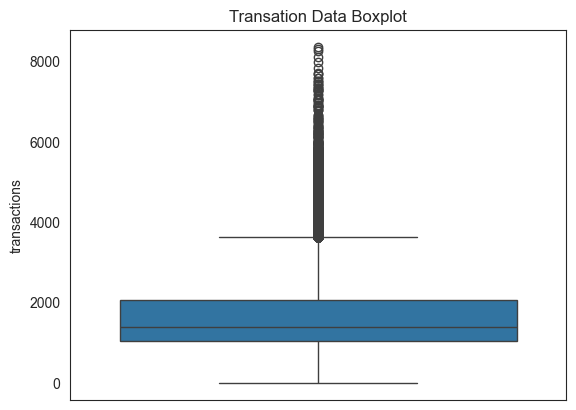

In [49]:
# Boxplot to show distribution of transactions
sns.boxplot(transaction_data['transactions'])
plt.title('Transation Data Boxplot')
plt.show()

### **Notes**
- There are some outliers in the transaction column
- There are no nulss or duplicates in the dataset

## **Analytical Questions**

**1. Is the train dataset complete (has all the required dates)?**


In [50]:
# Check for null values in the train dataset
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

**Dates Completion**

In [51]:
# Get the minimum and the mazimum dates
train_data['date'].min(), train_data['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [52]:
# save the min and max dates in variables
min_date = train_data['date'].min()
max_date = train_data['date'].max()

# Get the ecpected number of dates given the min and max dates
expected_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Get the actual number of dates
print(f"Expected number of unique dates: {len(expected_dates)},\nActual number of unique dates: {len(train_data['date'].unique())}")

Expected number of unique dates: 1688,
Actual number of unique dates: 1684


In [53]:
# Checking which dates are missing
missing_dates = expected_dates.difference(train_data['date'].unique())
missing_dates.to_list()

[Timestamp('2013-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-12-25 00:00:00')]



### Notes
- After checking for null values, we realize that the dataset has no null values. However, we will check whether all the dates are available.

- The minimum date is 2013-01-01, and the maximum date is 2017-08-15. After checking the range of dates between the minimum and maximum dates, we realize that the date column is not complete and is missing 4 dates.

- The missing dates are 2013-12-25, 2014-12-25, 2015-12-25, and 2016-12-25. After checking the missing dates, we realize that the 25th day of every December is missing, presumably because the day is Christmas, and most companies around the world are closed on Christmas.


**2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?**


Dates with the highest sales for each year
              date  year     sales
562596  2013-11-12  2013  46271.00
1257246 2014-12-08  2014  45361.00
1916586 2015-12-14  2015  40351.46
2163723 2016-05-02  2016 124717.00
2760297 2017-04-02  2017  38422.62


Text(0.5, 1.0, 'Dates with the highest sales for each year')

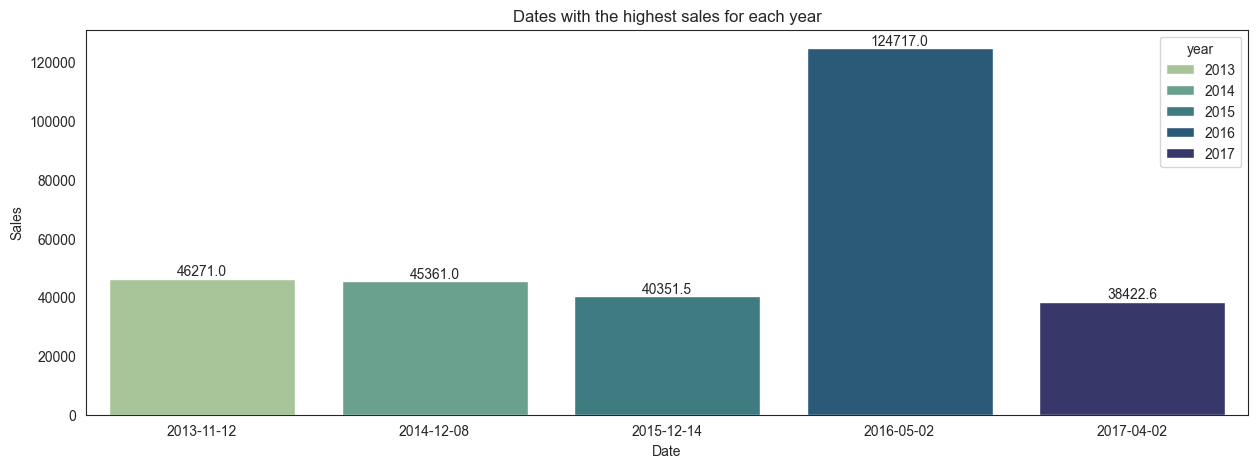

In [54]:
# Create a year column
train_data_cp['year'] = train_data_cp['date'].dt.year

# Reset index 
train_data_cp.reset_index(drop=True, inplace=True)

# Get the minimum and highest sales for each year (excluding days the store was closed)

min_sales = train_data_cp.groupby('year')['sales'].idxmin()
# Get the indices corresponding to the maximum sales for each year
max_sales= train_data_cp.groupby('year')['sales'].idxmax()

# Use these indices to locate the rows with maximum sales for each year
max_sales_rows = train_data_cp.loc[max_sales]
min_sales_rows = train_data_cp.loc[min_sales]

print("Dates with the highest sales for each year")

print(max_sales_rows[['date', 'year','sales']])

# visualize the hidgest sales data by date and year

plt.figure(figsize=(15,5))
sns.barplot(x=max_sales_rows['date'], y=max_sales_rows['sales'], hue=max_sales_rows['year'], palette='crest')
plt.xlabel('Date')
plt.ylabel('Sales')

# Data labels
for index, value in enumerate(max_sales_rows['sales']):
    label = f'{value:.1f}'  # Format value in Millions
    plt.text(index, value, label, ha='center', va='bottom')

plt.title('Dates with the highest sales for each year')

In [55]:
# print min sales for each year

print("Dates with the lowest sales for each year")

print(min_sales_rows[['date', 'year','sales']])

Dates with the lowest sales for each year
              date  year  sales
0       2013-01-01  2013   0.00
648648  2014-01-01  2014   0.00
1297296 2015-01-01  2015   0.00
1945944 2016-01-01  2016   0.00
2596374 2017-01-01  2017   0.00


### Notes 

- The first day of every year has the lowest sales for that year with zero sales being made.


**3. Compare the sales for each month across the years and determine which month of which year had the highest sales.**

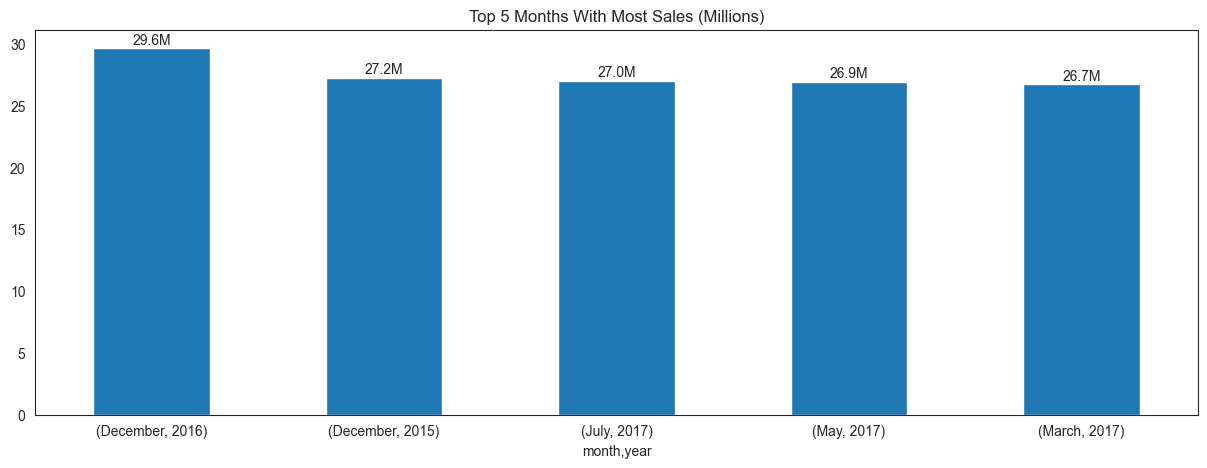

In [77]:
# Creating a column with the month names
train_data_cp['month'] = train_data_cp['date'].dt.month_name()

# Group sales by month and year
monthly_sales = train_data_cp.groupby(['month', 'year'])['sales'].sum().sort_values(ascending=False)

# Convert sales to millions
monthly_sales_millions = monthly_sales / 1000000

# Plotting the monthly sales
plt.figure(figsize=(15, 5))
ax = monthly_sales_millions.head(5).plot.bar()
plt.xticks(rotation=0)
plt.title('Top 5 Months With Most Sales (Millions)')
for i, v in enumerate(monthly_sales_millions.head(5)):
    plt.text(i, v + 0.1, f'{v:.1f}M', ha='center', va='bottom')
plt.show()

### **Notes**
- December of 2016 was the month with the most sales
- The month had 29.6M sales followed closely by December of 2015 which had 27.2M worth of sales